# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from os.path import basename
from random import shuffle
from rouge_score import rouge_scorer
from statistics import mean, stdev

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('punkt')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/teo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsSummarisationModel:
    def __init__(self, stop_words_file, elim_stops, lemmatise, n_grams):
        self._ALPHA = 1
        self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
        self.elim_stops = elim_stops
        self.lemmatise = lemmatise
        self.n_grams = n_grams

        self.class_app = {
            True: 0,
            False: 0
        }
        self.class_words = {
            True: {},
            False: {}
        }
        self.total_words = {
            True: 0,
            False: 0
        }
        self.total_sents = 0
        self.voc = set()

        self.wnl = WordNetLemmatizer()
        self.nlp = load('en')

        self.stop_words = set(stopwords.words('english')) | set(' ')
        with open(stop_words_file) as f:
            self.stop_words.union(set(token.replace('\n', '') for token in f))


    def _remove_chars(self, s):
        for ch in self._chars_to_remove:
            s = s.replace(ch, '')
        return s


    def _should_keep_token(self, tok):
        return tok not in self.stop_words if self.elim_stops else True


    def group_n_grams(self, words):
        return ['|'.join(words[i : i + self.n_grams])
            for i in range(len(words) - self.n_grams + 1)]


    def parse_sents(self, sents):
        lems = []
        for sent in sents:
            tokens = word_tokenize(sent) if self.lemmatise else sent.split()
            for tok in tokens:
                if self._should_keep_token(tok):
                    if self.lemmatise:
                        lem = self.wnl.lemmatize(self._remove_chars(tok).lower())
                    else:
                        lem = tok

                    if lem and (
                        not self.elim_stops
                        or lem not in self.stop_words
                    ):
                        lems.append(lem)

        return self.group_n_grams(lems)


    def _add_lems_to_class(self, lems, cl):
        for lem in lems:
            self.voc.add(lem)

            if lem in self.class_words[cl]:
                self.class_words[cl][lem] += 1
            else:
                self.class_words[cl][lem] = 1


    def add_file_summary(self, file, summ):
        with open(summ) as f:
            summ_str = f.read()
        with open(file) as f:
            file_sent = sent_tokenize(f.read())
            self.total_sents += len(file_sent)

        file_sent_keep = list(filter(lambda s: s in summ_str, file_sent))
        self.class_app[True] += len(file_sent_keep)

        summ_lems = self.parse_sents(file_sent_keep)
        self.total_words[True] += len(summ_lems)
        self._add_lems_to_class(summ_lems, True)

        file_sent_drop = list(filter(lambda s: s not in summ_str, file_sent))
        self.class_app[False] += len(file_sent_drop)

        drop_lems = self.parse_sents(file_sent_drop)
        self.total_words[False] += len(drop_lems)
        self._add_lems_to_class(drop_lems, False)


    def _compute_log_prob(self, word, cl):
        return log(
            (self.class_words[cl].get(word, 0) + self._ALPHA)
            / (self.total_words[cl] + len(self.voc) * self._ALPHA)
        )


    def _make_pred(self, sent):
        lems = self.parse_sents([sent])
        max_prob = -inf

        for cl in self.class_words:
            cl_prob = sum(
                map(lambda l: self._compute_log_prob(l, cl), lems),
                log(self.class_app[cl] / self.total_sents)
            )

            if max_prob < cl_prob:
                max_prob = cl_prob
                pred = cl

        return pred, max_prob


    def run_inference(self, file):
        with open(file) as f:
            sents = sent_tokenize(f.read())
        keeps = list(map(lambda s: self._make_pred(s), sents))
        predicted_sents = zip(sents, keeps)

        for pred, _ in keeps:
            if pred:
                return [sent for sent, keep in predicted_sents if keep[0]]

        predicted_sents = list(predicted_sents)
        predicted_sents.sort(key=lambda p: p[1][1])
        return [predicted_sents[0][0]]

In [3]:
def _get_files_summ(path):
    files = []
    for clss in listdir(f'{path}/News Articles'):
        files += list(map(
            lambda f: (
                f'{path}/News Articles/{clss}/{f}',
                f'{path}/Summaries/{clss}/{f}',
            ),
            listdir(f'{path}/News Articles/{clss}')
        ))

    shuffle(files)
    return files


def _get_train_test_files(path):
    files = _get_files_summ(path)
    num_files = len(files)
    num_tests = int(num_files / 4)

    test_files = files[:num_tests]
    train_files = files[num_tests:]

    return train_files, test_files, listdir(path)


def _run_tests(model, scorer, test_files, n_grams):
    recalls = []
    precs = []

    for file, summ in test_files:
        with open(summ) as f:
            true_summ = f.read()
        pred_summ = ' '.join(model.run_inference(file))
        scores = scorer.score(true_summ, pred_summ)[f'rouge{n_grams}']

        recalls.append(scores.recall)
        precs.append(scores.precision)

    return mean(recalls), mean(precs)


def _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams):
    plt.figure(figsize=(23,5))
    plt.plot(xs, precs, label='Precizie')
    plt.plot(xs, recalls, label='Regasire')
    
    plt.xlabel('Fisierele de antrenament', fontsize=20)
    plt.ylabel('Procentaj', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(fontsize=20)

    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'
    plt.title(
        f'Scor ROUGE-{n_grams} {lem} lematizare, {elim} eliminarea cuvintelor neinformative',
        fontsize=20
    )

    plt.grid()
    plt.show()
    
    print(f'Precizia {lem} lematizare, {elim} eliminare: {precs[len(precs) - 1]}')
    print(f'Regasirea {lem} lematizare, {elim} eliminare: {recalls[len(recalls) - 1]}')


def train_and_test(path, stop_words_file, elim_stops, lemmatise, n_grams):
    model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
    train_files, test_files, classes = _get_train_test_files(path)
    scorer = rouge_scorer.RougeScorer([f'rouge{n_grams}'], lemmatise)

    precs = []
    recalls = []
    xs = []
    i = 1

    for file, summ in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, scorer, test_files, n_grams)
            recalls.append(rec)
            precs.append(prec)

        model.add_file_summary(file, summ)
        i += 1

    xs.append(i)
    rec, prec = _run_tests(model, scorer, test_files, n_grams)
    recalls.append(rec)
    precs.append(prec)

    _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams)


def _get_file_groups(path, num_groups):
    files = _get_files_summ(path)

    num_files = len(files)
    chunk_size = int(num_files / num_groups)

    file_groups = [files[i*chunk_size : (i+1)*chunk_size]
        for i in range(num_groups)]

    return file_groups


def train_test_cross_validate(
    path,
    stop_words_file,
    elim_stops,
    lemmatise,
    n_grams,
    num_groups
):
    file_groups = _get_file_groups(path, num_groups)
    scorer = rouge_scorer.RougeScorer([f'rouge{n_grams}'], lemmatise)

    results = {'precision': {}, 'recall': {}}
    precs = []
    recalls = []

    for i in range(len(file_groups)):
        test_files = file_groups[i]
        train_groups = file_groups[:i] + file_groups[i+1:]
        train_files = sum(train_groups, [])

        model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
        [model.add_file_summary(file, summ) for file, summ in train_files]

        prec, rec = _run_tests(model, scorer, test_files, n_grams)
        precs.append(prec)
        recalls.append(rec)

    results['precision']['mean'] = mean(precs)
    results['recall']['mean'] = mean(recalls)
    results['precision']['stddev'] = stdev(precs)
    results['recall']['stddev'] = stdev(recalls)

    print(dumps(results, indent=4))

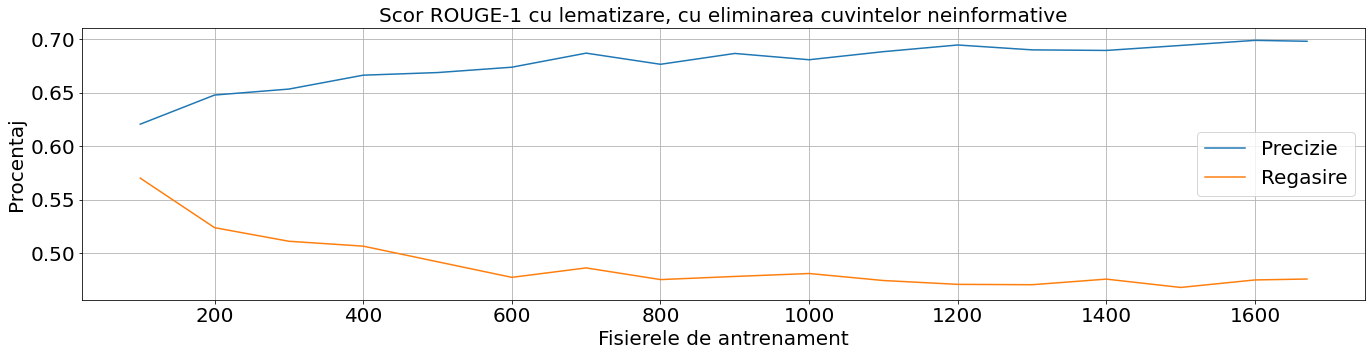

Precizia cu lematizare, cu eliminare: 0.6981263893120989
Regasirea cu lematizare, cu eliminare: 0.4758058931869102


In [4]:
train_and_test('BBC News Summary', 'stop_words', True, True, 1)

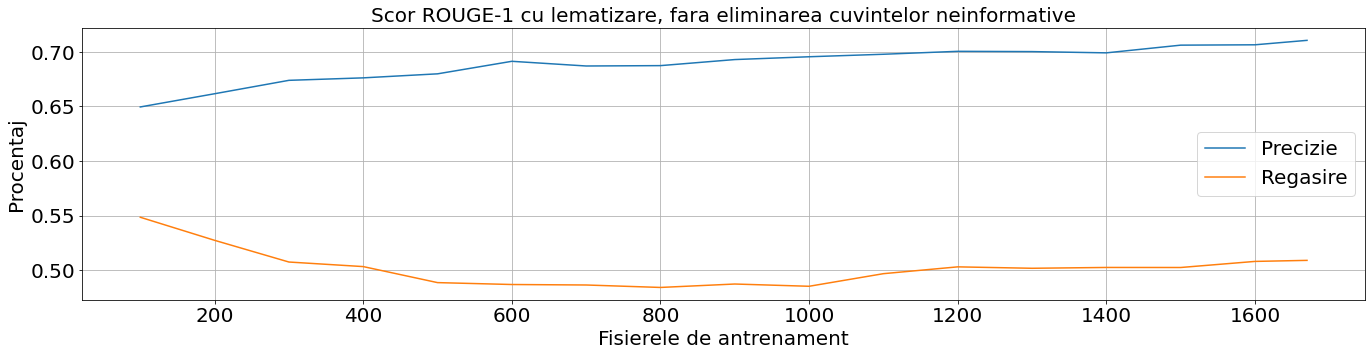

Precizia cu lematizare, fara eliminare: 0.7106017594910966
Regasirea cu lematizare, fara eliminare: 0.5089983426355843


In [5]:
train_and_test('BBC News Summary', 'stop_words', False, True, 1)

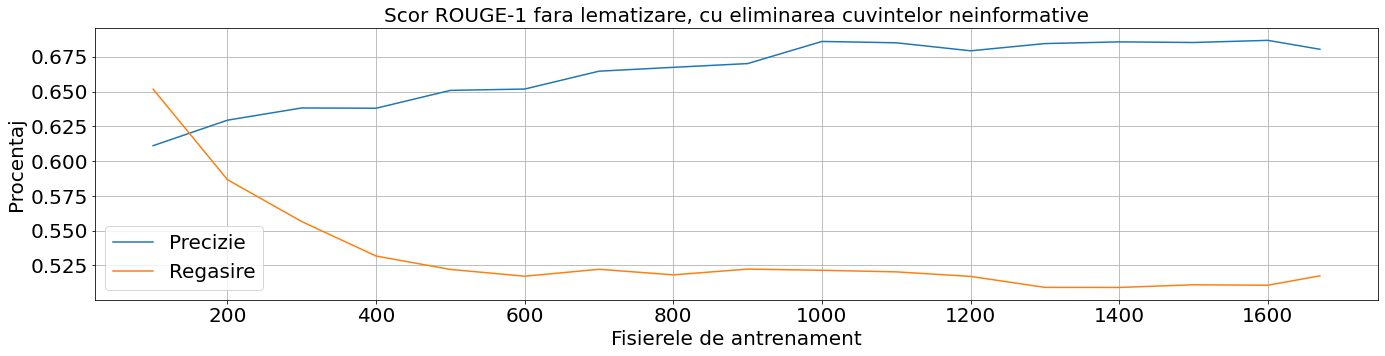

Precizia fara lematizare, cu eliminare: 0.6803800316466478
Regasirea fara lematizare, cu eliminare: 0.5175228562221396


In [6]:
train_and_test('BBC News Summary', 'stop_words', True, False, 1)

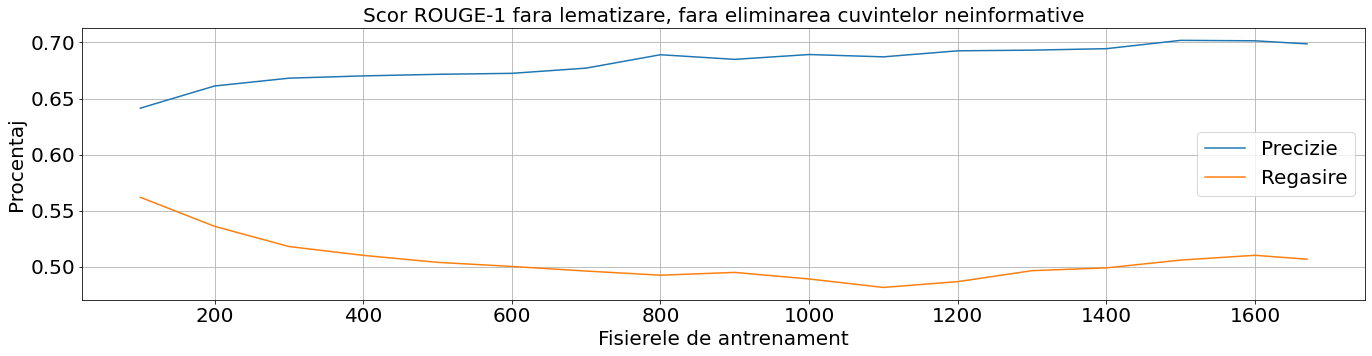

Precizia fara lematizare, fara eliminare: 0.6986914633439045
Regasirea fara lematizare, fara eliminare: 0.5067133417312537


In [7]:
train_and_test('BBC News Summary', 'stop_words', False, False, 1)

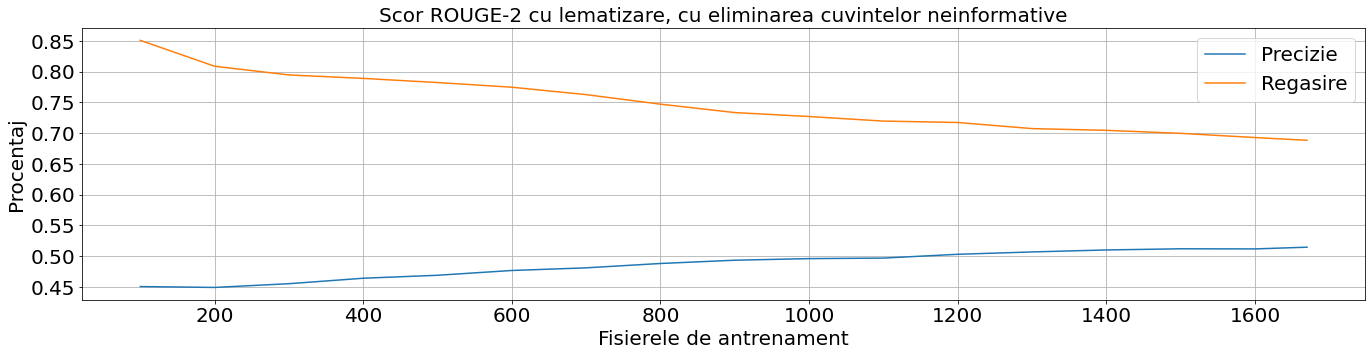

Precizia cu lematizare, cu eliminare: 0.514650379206011
Regasirea cu lematizare, cu eliminare: 0.6885066541294512


In [8]:
train_and_test('BBC News Summary', 'stop_words', True, True, 2)

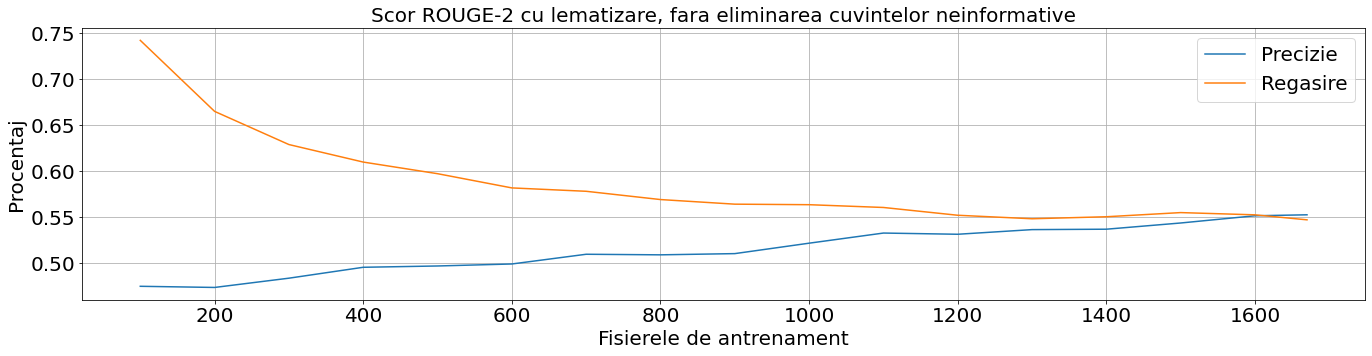

Precizia cu lematizare, fara eliminare: 0.5527428356985337
Regasirea cu lematizare, fara eliminare: 0.5472781064507435


In [9]:
train_and_test('BBC News Summary', 'stop_words', False, True, 2)

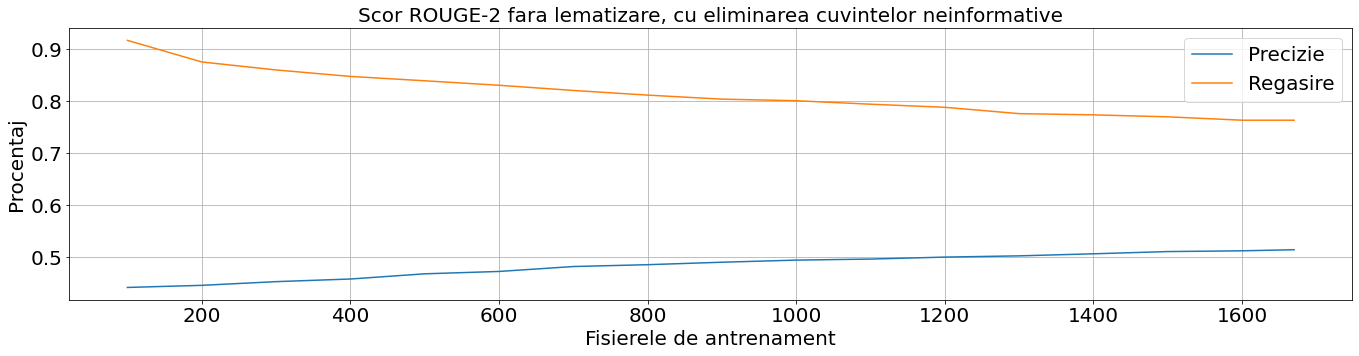

Precizia fara lematizare, cu eliminare: 0.5139181923289725
Regasirea fara lematizare, cu eliminare: 0.7633047383915111


In [10]:
train_and_test('BBC News Summary', 'stop_words', True, False, 2)

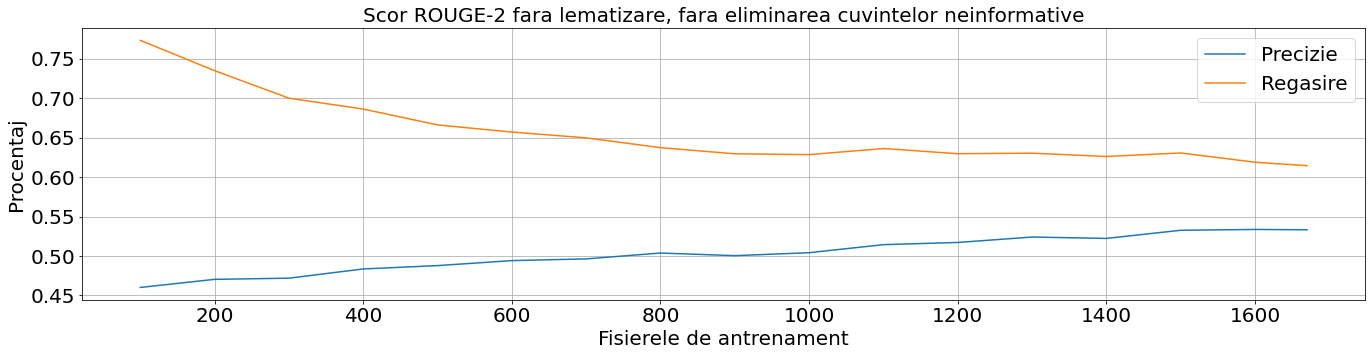

Precizia fara lematizare, fara eliminare: 0.5332104197793565
Regasirea fara lematizare, fara eliminare: 0.6143988173472752


In [11]:
train_and_test('BBC News Summary', 'stop_words', False, False, 2)

In [12]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 1, 5)

{
    "precision": {
        "mean": 0.4793997753071228,
        "stddev": 0.012390354985264206
    },
    "recall": {
        "mean": 0.7014111896246258,
        "stddev": 0.010052290259704609
    }
}


In [13]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 1, 5)

{
    "precision": {
        "mean": 0.4976870695465131,
        "stddev": 0.013072709530244194
    },
    "recall": {
        "mean": 0.7060870461617302,
        "stddev": 0.008386715699892
    }
}


In [14]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 1, 5)

{
    "precision": {
        "mean": 0.5186259240779267,
        "stddev": 0.01470011833913656
    },
    "recall": {
        "mean": 0.7028525490031671,
        "stddev": 0.01441125098836312
    }
}


In [15]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 1, 5)

{
    "precision": {
        "mean": 0.5207845069596357,
        "stddev": 0.012765152718097425
    },
    "recall": {
        "mean": 0.7100248056808074,
        "stddev": 0.007123088227566103
    }
}


In [16]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, True, 2, 5)

{
    "precision": {
        "mean": 0.6990332595265395,
        "stddev": 0.0087238211594543
    },
    "recall": {
        "mean": 0.5284710976300956,
        "stddev": 0.008230630910121607
    }
}


In [17]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, True, 2, 5)

{
    "precision": {
        "mean": 0.5568850251326964,
        "stddev": 0.01332937476595516
    },
    "recall": {
        "mean": 0.5618919218719581,
        "stddev": 0.01686108882052305
    }
}


In [18]:
train_test_cross_validate('BBC News Summary', 'stop_words', True, False, 2, 5)

{
    "precision": {
        "mean": 0.7675774133277374,
        "stddev": 0.008830345550372593
    },
    "recall": {
        "mean": 0.5250636413932894,
        "stddev": 0.011227918638243234
    }
}


In [19]:
train_test_cross_validate('BBC News Summary', 'stop_words', False, False, 2, 5)

{
    "precision": {
        "mean": 0.6109328520692303,
        "stddev": 0.009658871828032947
    },
    "recall": {
        "mean": 0.5533951246081557,
        "stddev": 0.009119780580114532
    }
}
